In [1]:
from toxic.model import get_model
from toxic.nltk_utils import tokenize_sentences
from toxic.train_utils import train_folds
from toxic.embedding_utils import read_embedding_list, clear_embedding_list, convert_tokens_to_ids

import argparse
import numpy as np
import os
import pandas as pd

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns


Using TensorFlow backend.


In [2]:
UNKNOWN_WORD = "_UNK_"
END_WORD = "_END_"
NAN_WORD = "_NAN_"

CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

PROBABILITIES_NORMALIZE_COEFFICIENT = 1.4

In [3]:
train_file_path = "/Users/sdivakarla/bbanalytics-telemetry-research/satish/SentimentAnalysis/data/WikiToxicity/KaggleToxicDataset/train.csv"
test_file_path = "/Users/sdivakarla/bbanalytics-telemetry-research/satish/SentimentAnalysis/data/WikiToxicity/KaggleToxicDataset/test.csv"
embedding_path = "/Users/sdivakarla/bbanalytics-telemetry-research/satish/SentimentAnalysis/model/crawl/crawl-300d-2M.vec"
print("Loading data...")
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

list_sentences_train = train_data["comment_text"].fillna(NAN_WORD).values
list_sentences_test = test_data["comment_text"].fillna(NAN_WORD).values
y_train = train_data[CLASSES].values

Loading data...


In [4]:
#marking comments without any tags as "clean"
rowsums=train_data.iloc[:,2:8].sum(axis=1)
train_data['clean']=(rowsums==0)
#count number of clean entries
train_data['clean'].sum()
print("Total comments = ",len(train_data))
print("Total clean comments = ",train_data['clean'].sum())
print("Total tags =",rowsums.sum())


Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [17]:
train_data[150:200]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,language
150,005ed4dfecd86188,"""\n\n Socialistm? \n\nThere are two important ...",0,0,0,0,0,0,en
151,005f59485fcddeb0,"""\n\nSORRY PUCK BUT NO ONE EVER SAID DICK WAS ...",1,0,0,0,0,0,en
152,005fb1983ff191e9,The Alpha version had multiplayer. The Beta ve...,0,0,0,0,0,0,en
153,0060062dd4db5195,"""\nPD: I just have seen that apart from the ar...",0,0,0,0,0,0,en
154,00604eb295a1dbf2,)\n\nWe are not treating this as a forum. A qu...,0,0,0,0,0,0,en
155,0060c5c9030b2d14,"""\n\n Military history WikiProject Newsletter ...",0,0,0,0,0,0,en
156,0060ef190ee10720,. Between the unblock submission and response...,0,0,0,0,0,0,en
157,006120d209a4a46c,"""\n\n \n\nYour request to be unblocked has be...",0,0,0,0,0,0,en
158,0061b075244dd234,"Once again, I responded to MileMoney's reasoni...",0,0,0,0,0,0,en
159,00637960a7ec3436,"""\n\nUNBLOCK ME OR I'LL GET MY LAWYERS ON TO Y...",1,0,0,0,0,0,en


In [4]:
from langdetect import detect
def detect_language(row):
    try:
        return detect(row)
    except:
        return "en"

In [5]:
train_data['language'] = train_data['comment_text'].apply(detect_language)

In [6]:
test_data['language'] = test_data['comment_text'].apply(detect_language)

In [7]:
from tools.extend_dataset import translate

In [36]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,language
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,en
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,en
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,en
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,en
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,en


In [ ]:
train_data.language.unique()

In [37]:
from joblib import Parallel, delayed
from textblob import TextBlob
from textblob.translate import NotTranslated

import argparse
import os
import numpy as np

NAN_WORD = "_NAN_"


def translate_to_english(comment, language):
    print(language)
    if hasattr(comment, "decode"):
        comment = comment.decode("utf-8")
    if language == "en":
        print("Lang is en")
        return comment
    else:
        text = TextBlob(comment)
        try:
            text = text.translate(from_lang=language, to="en")
        except NotTranslated:
            pass
        return str(text)

In [ ]:
train_data['new_comment_text'] = train_data.apply(lambda x: translate_to_english(x.comment_text, x.language), axis=1)
train_data.apply(translate_to_english)

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
sv
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
it
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
pl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
pt
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sk
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
it
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sq
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
hr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
no
en
Lang is en
id
en
Lang is en
en
Lang is en
pt
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
La

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sw
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sw
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
tr
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
hr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sv
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
it
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
pt
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
pt
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
ro
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
vi
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
ca
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
hu
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
ca
en
Lang is en

en
Lang is en
en
Lang is en
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sv
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sq
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
ca
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
pl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
hu
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
ro
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
hu
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sk
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
ca
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
pt
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
ta
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
en
La

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
it
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
La

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
pt
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sv
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
it
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sk
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
sq
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sv
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
La

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sv
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
da
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sv
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
so
en
Lang is en
en
Lang is en
en
Lang is en
en
La

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
fi
so
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
La

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
nl
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
vi
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sq
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
so
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


it
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
pl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
no
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
et
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sw
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
es
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
tl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
id
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
cy
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sw
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
de
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
sv
en
Lang is en
fr
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is 

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lan

en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
af
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
nl
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en
Lang is en
en


tl


In [22]:
train_data['new_comment_text'] = train_data.apply(lambda x: translate_to_english(train_data['comment_text'], train_data['language']), axis=1)

0         en
1         en
2         en
3         en
4         en
5         en
6         en
7         en
8         en
9         en
10        en
11        en
12        en
13        en
14        en
15        en
16        en
17        da
18        en
19        en
20        en
21        en
22        en
23        en
24        en
25        en
26        en
27        en
28        en
29        en
          ..
159541    en
159542    en
159543    en
159544    en
159545    en
159546    en
159547    en
159548    id
159549    sw
159550    en
159551    en
159552    en
159553    en
159554    en
159555    en
159556    en
159557    en
159558    en
159559    en
159560    en
159561    en
159562    en
159563    en
159564    en
159565    en
159566    en
159567    en
159568    en
159569    en
159570    en
Name: language, Length: 159571, dtype: object
0         en
1         en
2         en
3         en
4         en
5         en
6         en
7         en
8         en
9         en
10        en
11        en
12   

ValueError: ('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().', 'occurred at index 0')

In [13]:
# Translate the non-english to the english.
train_data['comment_text'] = train_data['comment_text'].apply(translate, args=(train_data['language'],))
test_data['comment_text'] = test_data['comment_text'].apply(translate, args=(test_data['language'],))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [9]:
print(len(train_data))
train_data_non_english= train_data[train_data['language']!='en']
print(len(train_data_non_english))

159571
4330


In [12]:
print(len(test_data))
test_data_non_english= test_data[test_data['language']!='en']
print(len(test_data_non_english))

153164
10319


In [16]:
test_data_non_english.to_csv("test_data_non_english.csv")

/Users/sdivakarla/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


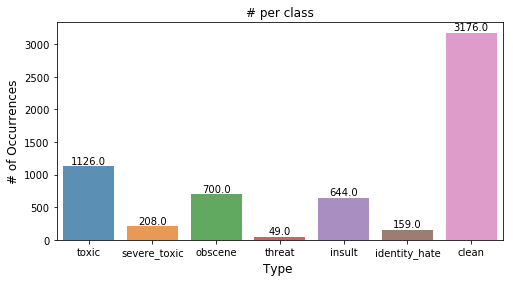

In [11]:
x=train_data_non_english.iloc[:,2:9].sum()

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [5]:
print("Tokenizing sentences in train set...")
tokenized_sentences_train, words_dict = tokenize_sentences(list_sentences_train, {})

print("Tokenizing sentences in test set...")
tokenized_sentences_test, words_dict = tokenize_sentences(list_sentences_test, words_dict)

  0%|          | 112/159571 [00:00<02:22, 1119.05it/s]

Tokenizing sentences in train set...


  0%|          | 146/153164 [00:00<01:46, 1437.55it/s]

Tokenizing sentences in test set...


100%|██████████| 153164/153164 [01:42<00:00, 1501.01it/s]


In [6]:
print(embedding_path)
words_dict[UNKNOWN_WORD] = len(words_dict)

print("Loading embeddings...")
embedding_list, embedding_word_dict = read_embedding_list(file_path=embedding_path)
embedding_size = len(embedding_list[0])

/Users/sdivakarla/bbanalytics-telemetry-research/satish/SentimentAnalysis/model/crawl/crawl-300d-2M.vec
Loading embeddings...


100%|██████████| 1999999/1999999 [04:04<00:00, 8182.93it/s]


In [7]:
print("Preparing data...")
embedding_list, embedding_word_dict = clear_embedding_list(embedding_list, embedding_word_dict, words_dict)

embedding_word_dict[UNKNOWN_WORD] = len(embedding_word_dict)
embedding_list.append([0.] * embedding_size)
embedding_word_dict[END_WORD] = len(embedding_word_dict)
embedding_list.append([-1.] * embedding_size)

embedding_matrix = np.array(embedding_list)

Preparing data...


In [9]:
print(embedding_matrix.shape)

(170075, 300)


In [9]:
sentences_length = 500
result_path = "toxic_results"
batch_size = 256
sentences_length = 500
recurrent_units=64
dropout_rate = 0.3
dense_size=32
fold_count=10

id_to_word = dict((id, word) for word, id in words_dict.items())
train_list_of_token_ids = convert_tokens_to_ids(tokenized_sentences_train,id_to_word,
                                                embedding_word_dict,sentences_length)
test_list_of_token_ids = convert_tokens_to_ids(tokenized_sentences_test,id_to_word,
                                               embedding_word_dict,sentences_length)
X_train = np.array(train_list_of_token_ids)
X_test = np.array(test_list_of_token_ids)

In [10]:
get_model_func = lambda: get_model(
    embedding_matrix,
    sentences_length,
    dropout_rate,
    recurrent_units,
    dense_size)

In [24]:
from keras.layers import Dense, Embedding, Input, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, Reshape
from keras.layers import Bidirectional, Dropout, CuDNNGRU, GRU
from keras.models import Model
from keras.optimizers import RMSprop

In [32]:
input_layer = Input(shape=(sentences_length,))
embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                weights=[embedding_matrix], trainable=False)(input_layer)
x = Bidirectional(GRU(recurrent_units, return_sequences=True))(embedding_layer)
x = Dropout(dropout_rate)(x)
x = Bidirectional(GRU(recurrent_units, return_sequences=True))(x)
x_max = GlobalMaxPool1D()(x)
x_avg = GlobalAveragePooling1D()(x)
x = concatenate([x_max, x_avg])
#x = Dense(dense_size, activation="relu")(x)
output_layer = Dense(6, activation="sigmoid")(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy',optimizer=RMSprop(clipvalue=1, clipnorm=1), metrics=['accuracy'])

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 500, 300)     51022500    input_14[0][0]                   
__________________________________________________________________________________________________
bidirectional_27 (Bidirectional (None, 500, 128)     140160      embedding_14[0][0]               
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 500, 128)     0           bidirectional_27[0][0]           
__________________________________________________________________________________________________
bidirectio

In [ ]:
print("Starting to train models...")
models = train_folds(X_train, y_train, fold_count, batch_size, get_model_func)

Starting to train models...
Epoch 1/1
143614/143614 [==============================] - 3288s 23ms/step - loss: 0.0648 - acc: 0.9770
Epoch 0 loss 0.04540272414923855 best_loss -1
Epoch 1/1
106752/143614 [=====================>........] - ETA: 15:03 - loss: 0.0445 - acc: 0.9830

In [ ]:
result_path = toxic_results
if not os.path.exists(result_path):
        os.mkdir(result_path)

In [ ]:
print("Predicting results...")
test_predicts_list = []
for fold_id, model in enumerate(models):
    model_path = os.path.join(args.result_path, "model{0}_weights.npy".format(fold_id))
    np.save(model_path, model.get_weights())
    test_predicts_path = os.path.join(args.result_path, "test_predicts{0}.npy".format(fold_id))
    test_predicts = model.predict(X_test, batch_size=args.batch_size)
    test_predicts_list.append(test_predicts)
    np.save(test_predicts_path, test_predicts)

In [ ]:
test_predicts = np.ones(test_predicts_list[0].shape)
for fold_predict in test_predicts_list:
    test_predicts *= fold_predict
    test_predicts **= (1. / len(test_predicts_list))
    test_predicts **= PROBABILITIES_NORMALIZE_COEFFICIENT
    
    test_ids = test_data["id"].values
    test_ids = test_ids.reshape((len(test_ids), 1))

    test_predicts = pd.DataFrame(data=test_predicts, columns=CLASSES)
    test_predicts["id"] = test_ids
    test_predicts = test_predicts[["id"] + CLASSES]
    submit_path = os.path.join(args.result_path, "submit")
    test_predicts.to_csv(submit_path, index=False)